## Setting up dependencies

In [2]:
!pip3 install kaggle

In [3]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!cp kaggle.json ~/.kaggle/kaggle.json

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100%|█████████████████████████████████████▉| 2.29G/2.29G [00:27<00:00, 85.0MB/s]
100%|██████████████████████████████████████| 2.29G/2.29G [00:30<00:00, 81.8MB/s]


In [7]:
import zipfile
with zipfile.ZipFile('./chest-xray-pneumonia.zip','r') as zip_ref:
    zip_ref.extractall('./data')

## Image preprocessing and folder restructuring

In [10]:
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline

# dir : test/train/val
# condition : n/p
def get_random_image(dir,condition):
  placeholder = ''
  if condition=='n':
    placeholder='NORMAL'
  elif condition=='p':
    placeholder='PNEUMONIA'
  else:
    raise Exception('Invalid Condition')

  folder=f'./data/chest_xray/{dir}/{placeholder}/*.jpeg'
  img_paths=glob.glob(folder)
  max_length=len(img_paths)
  randomNumber=random.randint(0,max_length)

  for index,item in enumerate(img_paths,start=1) :
    if index==randomNumber:
      print(index,item)
      image=plt.imread(item)
      readyImage=plt.imshow(image) # imshow requires an array that's why we perform an imread first
      return readyImage

3 ./data/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg


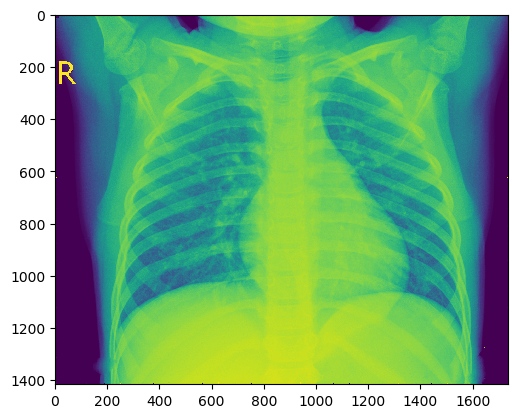

In [11]:
get_random_image('val','n')

Matplotlib saves the grayscale input img in its own default rgb scale, we must retain the grayscale for better predictions.

We plan on using sagemaker's default image-classifier, so we resize the images to its needed default value which is (224,224) 
with 3 input channels (not l, not rgba but rgb) : https://keras.io/api/applications/resnet/#resnet152v2-function

Also, for ease of access, let's save all normal and pneumonia images in one folder each for train,test,val.

In [13]:
from PIL import Image

img=Image.open('./data/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg')
print(img.format)
print(img.size)
print(img.mode) # color scale : https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes

JPEG
(1776, 1416)
L


In [14]:
folder='./data/chest_xray/train/*/*.jpeg'

counterPneu=0
counterNorm=0

# counters because we're planning on saving those imgs in one directory preserving the lables : 
# train_pneumonia0.jpeg, train_pneumonia1.jpeg |  train_normal0.jpeg train_normal1.jpeg 

img_paths=glob.glob(folder)

for i in img_paths:
  if 'person' in i:
    full_size_image=Image.open(i)
    im=full_size_image.resize((224,224))
    plt.imsave(fname='./data/chest_xray/train/'+'train_pneumonia'+str(counterPneu)+'.jpeg',arr=im,format='jpeg',cmap='gray')
    counterPneu+=1
  else:
    full_size_image=Image.open(i)
    im=full_size_image.resize((224,224))
    plt.imsave(fname='./data/chest_xray/train/'+'train_normal'+str(counterNorm)+'.jpeg',arr=im,format='jpeg',cmap='gray')
    counterNorm+=1

In [15]:
folder='./data/chest_xray/test/*/*.jpeg'

counterPneu=0
counterNorm=0

# counters because we're planning on saving those imgs in one directory preserving the lables : 
# test_pneumonia0.jpeg, test_pneumonia1.jpeg |  test_normal0.jpeg test_normal1.jpeg 

img_paths=glob.glob(folder)

for i in img_paths:
  if 'person' in i:
  # ie if its an image of a person with pneumonia
    full_size_image=Image.open(i)
    im=full_size_image.resize((224,224))
    plt.imsave(fname='./data/chest_xray/test/'+'test_pneumonia'+str(counterPneu)+'.jpeg',arr=im,format='jpeg',cmap='gray')
    counterPneu+=1
  else:
    full_size_image=Image.open(i)
    im=full_size_image.resize((224,224))
    plt.imsave(fname='./data/chest_xray/test/'+'test_normal'+str(counterNorm)+'.jpeg',arr=im,format='jpeg',cmap='gray')
    counterNorm+=1

In [16]:
# technically there is no need to resize validation set because sagemaker is not going to use that. 
# But we are going to use it for evaluation. (SageMaker will validate the model using the test imgs)

folder='./data/chest_xray/val/*/*.jpeg'

counterPneu=0
counterNorm=0

# counters because we're planning on saving those imgs in one directory preserving the lables : 
# val_pneumonia0.jpeg, val_pneumonia1.jpeg |  val_normal0.jpeg val_normal1.jpeg 

img_paths=glob.glob(folder)

for i in img_paths:
  if 'person' in i:
  # ie if its an image of a person with pneumonia
    full_size_image=Image.open(i)
    im=full_size_image.resize((224,224))
    plt.imsave(fname='./data/chest_xray/val/'+'val_pneumonia'+str(counterPneu)+'.jpeg',arr=im,format='jpeg',cmap='gray')
    counterPneu+=1
  else:
    full_size_image=Image.open(i)
    im=full_size_image.resize((224,224))
    plt.imsave(fname='./data/chest_xray/val/'+'val_normal'+str(counterNorm)+'.jpeg',arr=im,format='jpeg',cmap='gray')
    counterNorm+=1

We can now delete the NORMAL and PNEUMONIA directories as we already have the images in 1 directory

## Create dataframe for visualization

In [17]:
import pandas as pd

folder='./data/chest_xray/*/*.jpeg'

category=[]
condition_of_lung=[]
filenames=[]

all_files=glob.glob(folder)

for filename in all_files:
  if 'train' in filename:
    if 'pneumonia' in filename:
      category.append('train')
      filenames.append(filename)
      condition_of_lung.append('pneumonia')
    elif 'normal' in filename:
      category.append('train')
      filenames.append(filename)
      condition_of_lung.append('normal')
  elif 'test' in filename:
    if 'pneumonia' in filename:
      category.append('test')
      filenames.append(filename)
      condition_of_lung.append('pneumonia')
    elif 'normal' in filename:
      category.append('test')
      filenames.append(filename)
      condition_of_lung.append('normal')
  elif 'val' in filename:
    if 'pneumonia' in filename:
      category.append('val')
      filenames.append(filename)
      condition_of_lung.append('pneumonia')
    elif 'normal' in filename:
      category.append('val')
      filenames.append(filename)
      condition_of_lung.append('normal')

all_data_df=pd.DataFrame({'dataset_type':category,'xray_result':condition_of_lung,'filename':filenames})
print(all_data_df.head())

  dataset_type xray_result                                       filename
0         test      normal       ./data/chest_xray/test/test_normal4.jpeg
1         test   pneumonia    ./data/chest_xray/test/test_pneumonia1.jpeg
2         test   pneumonia  ./data/chest_xray/test/test_pneumonia359.jpeg
3         test   pneumonia  ./data/chest_xray/test/test_pneumonia197.jpeg
4         test      normal     ./data/chest_xray/test/test_normal103.jpeg


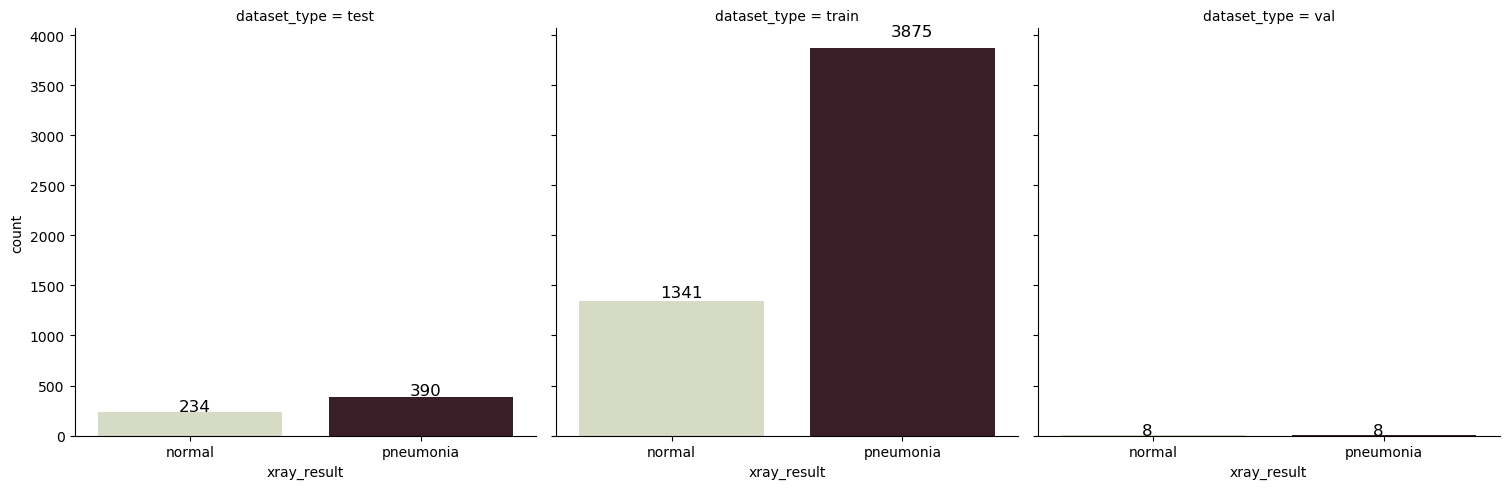

In [18]:
# visualization
import seaborn as sns
g=sns.catplot(x='xray_result',col='dataset_type',kind='count',palette='ch:.55',data=all_data_df,legend=True)

for i in range(0,3):
  ax=g.facet_axis(0,i)
  for p in ax.patches:
    ax.text(p.get_x()+0.35,
    p.get_height()*1.03,
    '{0:.0f}'.format(p.get_height()),
    color='black',
    rotation='horizontal',
    size='large')

SageMaker is going to look for .lst files for training.
train.lst and test.lst need to be uploaded to the s3 bucket

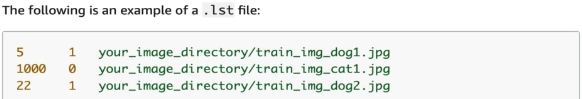

col 1 indicates the img index, 2nd is the class label and 3rd is the img path

## Creating pandas dataframe for .lst files

In [19]:
import os

In [20]:
train_folder='./data/chest_xray/train/*.jpeg'
train_df_lst=pd.DataFrame(columns=['labels','s3_path'])
train_imgs_path=glob.glob(train_folder)
counter=0
class_arg=''

for i in train_imgs_path:
  if 'pneumonia' in i:
    class_arg=1
  else:
    class_arg=0
  train_df_lst.loc[counter]=[class_arg,os.path.basename(i)]
  counter+=1

print(train_df_lst.head())

  labels                   s3_path
0      0     train_normal1203.jpeg
1      1  train_pneumonia3349.jpeg
2      1   train_pneumonia478.jpeg
3      1  train_pneumonia1567.jpeg
4      1  train_pneumonia2296.jpeg


In [21]:
test_folder='./data/chest_xray/test/*.jpeg'
test_df_lst=pd.DataFrame(columns=['labels','s3_path'])
test_imgs_path=glob.glob(test_folder)
counter=0
class_arg=''

for i in test_imgs_path:
  if 'pneumonia' in i:
    class_arg=1
  else:
    class_arg=0
  test_df_lst.loc[counter]=[class_arg,os.path.basename(i)]
  counter+=1

print(test_df_lst.head())

  labels                 s3_path
0      0       test_normal4.jpeg
1      1    test_pneumonia1.jpeg
2      1  test_pneumonia359.jpeg
3      1  test_pneumonia197.jpeg
4      0     test_normal103.jpeg


In [22]:
def save_to_lst(df,prefix):
  return df[['labels','s3_path']].to_csv(
      f'{prefix}.lst',sep='\t',index=True,header=False
  )

save_to_lst(train_df_lst.copy(),'train')
save_to_lst(test_df_lst.copy(),'test')

## Setup s3 

In [23]:
# upload images and .lst files to s3
# go to management console, got s3 and create a new bucket: give the name "xray-imgs", check the region and create
bucket='xray-imgs'
print('bucket:{}'.format(bucket))
region='us-east-2'
print('region:{}'.format(region))
roleArn='arn:aws:s3:::xray-imgs'
print('roleArn:{}'.format(roleArn))

bucket:xray-imgs
region:us-east-2
roleArn:arn:aws:s3:::xray-imgs


In [24]:
os.environ['DEFAULT_S3_BUCKET']=bucket

In [25]:
# this is gonna create a train folder in our s3 bucket and upload our train imgs
!aws s3 sync ./data/chest_xray/train s3://${DEFAULT_S3_BUCKET}/train/

upload: data/chest_xray/train/train_normal1.jpeg to s3://xray-imgs/train/train_normal1.jpeg
upload: data/chest_xray/train/train_normal1001.jpeg to s3://xray-imgs/train/train_normal1001.jpeg
upload: data/chest_xray/train/train_normal1000.jpeg to s3://xray-imgs/train/train_normal1000.jpeg
upload: data/chest_xray/train/train_normal100.jpeg to s3://xray-imgs/train/train_normal100.jpeg
upload: data/chest_xray/train/train_normal10.jpeg to s3://xray-imgs/train/train_normal10.jpeg
upload: data/chest_xray/train/train_normal101.jpeg to s3://xray-imgs/train/train_normal101.jpeg
upload: data/chest_xray/train/train_normal0.jpeg to s3://xray-imgs/train/train_normal0.jpeg
upload: data/chest_xray/train/train_normal1005.jpeg to s3://xray-imgs/train/train_normal1005.jpeg
upload: data/chest_xray/train/train_normal1011.jpeg to s3://xray-imgs/train/train_normal1011.jpeg
upload: data/chest_xray/train/train_normal1008.jpeg to s3://xray-imgs/train/train_normal1008.jpeg
upload: data/chest_xray/train/train_norm

In [26]:
!aws s3 sync ./data/chest_xray/test s3://${DEFAULT_S3_BUCKET}/test/

upload: data/chest_xray/test/test_normal0.jpeg to s3://xray-imgs/test/test_normal0.jpeg
upload: data/chest_xray/test/test_normal100.jpeg to s3://xray-imgs/test/test_normal100.jpeg
upload: data/chest_xray/test/test_normal107.jpeg to s3://xray-imgs/test/test_normal107.jpeg
upload: data/chest_xray/test/test_normal1.jpeg to s3://xray-imgs/test/test_normal1.jpeg
upload: data/chest_xray/test/test_normal10.jpeg to s3://xray-imgs/test/test_normal10.jpeg
upload: data/chest_xray/test/test_normal101.jpeg to s3://xray-imgs/test/test_normal101.jpeg
upload: data/chest_xray/test/test_normal111.jpeg to s3://xray-imgs/test/test_normal111.jpeg
upload: data/chest_xray/test/test_normal108.jpeg to s3://xray-imgs/test/test_normal108.jpeg
upload: data/chest_xray/test/test_normal103.jpeg to s3://xray-imgs/test/test_normal103.jpeg
upload: data/chest_xray/test/test_normal109.jpeg to s3://xray-imgs/test/test_normal109.jpeg
upload: data/chest_xray/test/test_normal104.jpeg to s3://xray-imgs/test/test_normal104.jpe

In [28]:
# import .lst files to s3 using a python sdk from aws s3
import boto3
boto3.Session().resource('s3').Bucket(bucket).Object('train.lst').upload_file('./train.lst')

In [29]:
boto3.Session().resource('s3').Bucket(bucket).Object('test.lst').upload_file('./test.lst')

## Setting up estimator object for training

Estimate is just basically the name that Amazon gave the object that we're going to give to to Amazon with the specifications that we want and how it should train the model.

Now check the bucket and its objects. Next we're setting up our estimate or object, which is going to hold our algorithm Docker image where the image classifier is is located.
We're going to pull that Docker image from Amazon's elastic container registry. 

We need to rerun the cell after setup of s3 because after disconnecting sagemaker it forgets the variables.

In [ ]:
import sagemaker
from sagemaker import image_uris
import boto3
from sagemaker import get_execution_role

sess=sagemaker.Session() # it's an object that manages interactions with Amazon sagemaker APIs and any other AWS service

# algorithm_image is going to be the Docker image for the image classifier that we're going to pull from Amazon's elastic container registry (ECR)
# ECR is a fully managed Docker container registry that makes it easy to store, share and deploy container images
algorithm_image=image_uris.retrieve(
    region=boto3.Session().region_name,
    framework='image-classification' # this is going to tell Amazon to get the latest image classifier Docker image from ECR
)

s3_output_location=f's3://{bucket}/models/image_model'
print(algorithm_image)

In [ ]:
role=get_execution_role()
print(role)

In [62]:
# define the estimator

# instance_count=1 is the number of EC2 instances we're going to use for training.
# And because we have few thousands of training images, we don't need to use multi instance training.
# But you could set this two to two or three or whatever number you want.
# But do note that the more instances you have, the faster it's going to train.
# Although you might lose some accuracy because it trains more efficiently when when you have all the images
# training on one instance.
# But when you have millions of data, then you probably should do multi instance training.

# NOTE: when you see a p in an instant type, that means it has a GPU in it
 
img_classifier_model=sagemaker.estimator.Estimator(
    algorithm_image,
    role=role,
    instance_count=1,
    instance_type='ml.p2.xlarge',
    volume_size=50, # 50 GB for storing images in local
    max_run=432000, # terminate the training after 3600000 seconds
    input_mode='File',
    output_path=s3_output_location,
    sagemaker_session=sess,
)

print(img_classifier_model) # print the estimator

## Setting up hyperparameter tuning

In [63]:
count=0
for file in glob.glob('./data/chest_xray/train/*.jpeg'):
  count+=1
print(count) # prints the number of images in train directory to be trained with

5216


In [80]:
# the estimator object defined above has a set of hyper parameters, a property on it, and we're going to use that to configure our hyper parameter tuning job

# Our images are actually two dimensional because they're grayscale images.
# However, image shape is three dimensional because we have the three color
# channels, which would be rgb. But, do remember that you cannot convert a grayscale image to be an RGB image.
# So over here, sagemaker is smart enough to look at our images and see that, they are not rgb, so it actually 
# adds extra dimensions to our images. And that way we can use the image classifier algorithm without any hassle.
# So that's why we have to specify this shape over here.
# If you go into the documentation, you see that this is the shape that the algorithm expects.
# So if you have color images, then you don't have to worry about anything; even though it's grayscale, 
# it's going to behave as if it's non-grayscale image

# lr_scheduler_factor=0.1, it decreases the learning rate by this factor.
# once you get closer to the global minimum, you want to take smaller steps in order to not overshoot
# and actually go to a local minima instead of the global minimum.
# So as you're getting closer to your ideal solution, you want to take smaller steps.

# After Epoch 8, 10 and 12, lr_scheduler_step is going to decrease the learning rate because we're getting closer
# to our final epochs. So once we're getting closer to our final epochs, we want to take smaller steps to find the ideal solution.
# Now, obviously, this 8, 10 and 12 would not be a good learning rate scheduler step if we were
# training for the ideal 50 epochs because ideally you would want to train for like 50 epochs have the
# early stopping be a minimum epochs be at like 30. And these would be around like 25 30 and like 35, 
# because once you've been training for long enough, then you want to start taking smaller steps.

# augmentation_type='crop_color_transformation' applies random augmentations such as rotations and shearings 
# and other augmentations to the images. And this way, our dataset is going to be more varied and we're going 
# to be able to avoid overfitting. It's especially useful when our dataset is a bit unbalanced because
# we have more images that depict pneumonia than images that don't.

img_classifier_model.set_hyperparameters(
    image_shape='3,224,224',
    num_classes=2,
    use_pretrained_model=1, # turn on transfer learning
    num_training_samples=count,
    augmentation_type='crop_color_transform',
    epochs=15, # this will give an accuracy around 80%, for an enterprise system you might wanna use 30-50 epochs for an accuracy upto 95-96% (more training, more cost)
    early_stopping=True,
    early_stopping_min_epochs=8, # ~30 if epochs=50
    early_stopping_patience=5,
    early_stopping_tolerance=0.0,
    lr_scheduler_factor=0.1,
    lr_scheduler_step='8,10,12',
)

In [81]:
# specify the dynamic hyperparameters (learning rate, mini batch size, optimizer) that we want to tune 
from sagemaker.tuner import CategoricalParameter,ContinuousParameter,HyperparameterTuner 

# we're telling sagemaker that learning_rate is a continuous parameter, meaning that for every single training job, 
# it should look at values between 0.01 and 0.1 for the learning_rate

# Mini batch basically is the number of training examples in one forward and backward pass.
# So the higher the batch size is, the more memory that it will take but it will also be more 
# accurate unless it converges to the wrong directions. And when you have a batch_size of, for example 1, 
# then that loads in memory very fast but it oscillates and it converges all over the place because 
# the model updates itself after just reviewing and looking at one image. So the ideal parameters are 8, 16 and 32 
# because these numbers are small enough so that they fit in the memory.
# 8, for example, means hey sagemaker update your model after you've' looked at 8 different images.
# So eight, 16 and thirty two are ideal. And, they're big enough that the model doesn't converge and 
# oscillate all over the place when looking for global minima.

hyperparameter_ranges={
    'learning_rate':ContinuousParameter(0.01,0.1), 
    'mini_batch_size':CategoricalParameter([8,16,32]),
    'optimizer':CategoricalParameter(['sgd','adam'])
}

## Setting up the Training Job

In [82]:
# we're going to define some boilerplate code, and then we're also going to have to define the objective metric 
# that we're going to look at during training and how many tuning jobs we want to set and how many parallel jobs we want to do.

# objective is to maximize the accuracy. If this were some kind of regression problem 
# and we were looking at like the root mean square error, then we would've wanted to minimize this.

# let's set up 5 hyperparameter tuning jobs, so that's going to train the whole model five
# times with different hyperparameters and with different values that we have input in the hyper parameter
# ranges, and we can also specify the max parallel jobs. right now, I'm going to set it to 1 because 
# we don't have that much data.If you have millions of images, then you'd probably 
# want to do parallel jobs for the hyperparameter tuning jobs.Plus, we don't want it to be too expensive.
# And also, if you don't want to pay as much, then you can lower this number(max_jobs) to 2 or just 1.

# And the reason we're setting the max parallel jobs to one is because the default hyperparameter tuner
# is going to use a technique called Bayesian search. Now, if we come over to the documentation and we 
# look at the hyperparameter tuner, we see that when choosing the best hyperparameters for the next training job, 
# the hyperparameter tuning considers everything that it knows about this problem so far.
# Because we're using Bayesian search, it means that it's going to look at the previous training
# jobs and it's going to infer some results based off of that. So we don't want to run too many jobs 
# in parallel, because if we do, then our Bayesian search is not going to be able to look at previous 
# results and build on top of them. So basically, if it realizes that every time it uses the minimum 
# size of 16, it gets better results than it would with 8. It's going to stick to 16.
# But if we set this max payload jobs to five, then it's not going to be able to learn anything from
# the previous jobs. Now, obviously, if we had a max jobs of like 50, then then we would want to do 
# like 3/4/5 parallel jobs or even more.

objective_metric_name='validation:accuracy'
objective_type='Maximize'
max_jobs=2 # try 5
max_parallel_jobs=1

In [83]:
tuner=HyperparameterTuner(estimator=img_classifier_model,
                          objective_metric_name=objective_metric_name,
                          hyperparameter_ranges=hyperparameter_ranges,
                          objective_type=objective_type,
                          max_jobs=max_jobs,
                          max_parallel_jobs=max_parallel_jobs
                          )

In [84]:
# before calling the fit method on the tuner we're going to specify where the model inputs are and the names of the training jobs
from sagemaker.session import TrainingInput

model_inputs={
    'train':sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket}/train/',content_type='application/x-image'),
    'validation':sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket}/test/',content_type='application/x-image'), # sagemaker calls this validation but it is test
    'train_lst':sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket}/train.lst',content_type='application/x-image'),
    'validation_lst':sagemaker.inputs.TrainingInput(s3_data=f's3://{bucket}/test.lst',content_type='application/x-image'),
}

In [85]:
# give unique job names
import time
job_name_prefix='classifier'
timestamp=time.strftime('-%Y-%m-%d-%H-%M-%S',time.gmtime())
job_name=job_name_prefix+timestamp

In [86]:
# read cell below before running this cell
tuner.fit(inputs=model_inputs,job_name=job_name,logs=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
# But before we start training (run the previous cell), I do want to note that we don't want our data to be on this elastic file system
# because we're paying for it. So what I want you to do is delete the test and the train folder.
# I don't want you to delete the validation folder because we barely have any images.
# And we're going to use it for testing.

# headover to Amazon CloudWatch where you'll be able to monitor how our training is currently doing.
# go to Log Groups and search for training jobs if not already there, look at log streams now

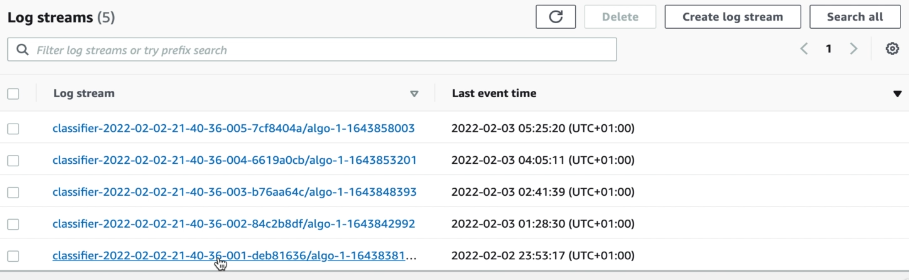

In [ ]:
# for us we've set the training jobs=2 unlike in above with 5. check on each and see which one has the best validation accuracy and select that model
# but comparing each manually is tedious so you can search the Log Groups for 'validation accuarcy' and look through. An even better approach would be to 
# create a metric filter. But, an even easier way would be to go to Amazon SageMaker and then Training-->Hyperparameter tuning jobs where you can just click on the best 
# training job to get its best hyperparameters. We will evaluate the best model (which also gets saved in s3 bucket)

# now lets do some local inference and then deploy the best model 

## Inference

In [91]:
from sagemaker import get_execution_role
role=get_execution_role()

model=sagemaker.model.Model(
    image_uri=algorithm_image,
    # SageMaker-->Training-->Hyperparameter tuning jobs-->Best training job: copy the name 'classifier...'
    # S3-->medical_ai_chest_xray-->models-->image_model: find the best model (ctrlF and ctrlV) click on that --> output-->model.tar.gz--> (copy its s3 uri and paste below)
    model_data='s3://xray-imgs/models/image_model/classifier-2023-03-14-05-03-22-001-94ef300f/output/model.tar.gz',
    role=role
)

### Create an endpoint

In [93]:
endpoint_name='Demo-image-classifier-Pneumonia-01'

deployment=model.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    endpoint_name=endpoint_name
)
# after this code is run, the endpoint is deployed: go to sagemaker-->Inference-->Endpoints
# # for enterprise this endpoint will remain active 24/7 
# However, if it's for your own project while you want to learn, then I would recommend you to shut
# the endpoint down when we're done with the evaluation and then redeploy the endpoint when we're going
# to open up our endpoint to the internet, where we can serve inferences from there

-----------!

### Local inference

In [111]:
# lets do some local inference using the data we got in our validation folder
from sagemaker.predictor import Predictor
predictor=Predictor('Demo-image-classifier-Pneumonia-01')

In [120]:
from sagemaker.serializers import IdentitySerializer
import base64

file_name='./data/chest_xray/val/val_normal0.jpeg'
predictor.serializer=IdentitySerializer('image/jpeg')

with open(file_name, 'rb') as f:
  payload=f.read()

inference=predictor.predict(data=payload)
print(inference)

b'[0.9816956520080566, 0.018304388970136642]'


In [121]:
print(inference[0]) # we don't get the expected o/p of probability because it's a byte array, so to get that we first have to deserialize

91


### Evaluation

In [122]:
# now we're going to do inference for every single file in val folder and then we're going 
# to deserialize them to then create the confusion matrix and the classification report as well
import numpy as np
import json

file_path='./data/chest_xray/val/val*.jpeg'
files=glob.glob(file_path)

y_true=[]
y_pred=[]

def make_pred():
    for file in files:
        if 'normal' in file:
            with open(file,'rb') as f:
                payload=f.read()
                inference=predictor.predict(data=payload).decode('utf-8')
                result=json.loads(inference) # json.loads is used to deserialize a byte array
                predicted_class=np.argmax(result) # if there is [0.1,0.98] argmax will return the index of larger val ie 1 here
                y_true.append(0) # because file has normal ie it does not have pneumonia
                y_pred.append(predicted_class)
        elif 'pneumonia' in file:
            with open(file,'rb') as f:
                payload=f.read()
                inference=predictor.predict(data=payload).decode('utf-8')
                result=json.loads(inference)
                predicted_class=np.argmax(result)
                y_true.append(1)
                y_pred.append(predicted_class)
    
make_pred()
print(y_true)
print(y_pred)

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0]
[0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0]


In [123]:
# create a confusion matrix 
# when doing a medical imaging with DL, we want our false negatives (bottom left) minimized (here, we have a zero)
# ie you dont want your model to say you dont have pneumonia when actually you do 
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true,y_pred)

array([[6, 2],
       [0, 8]])

In [124]:
# create classification report
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



In [ ]:
# now 90% of the times the best model will give the best metrics but some of the times it's the others
# you can try the training jobs repeating the process by updating the endpoint (rename and replace uri)

# also, now that we have our metrics, we can start off by creating our lamba function which calls the endpoint when a request from the internet comes in

# NOTE ON SHUTTING DOWN ENDPOINT: 
# SageMaker-->Inference-->Endpoints-->ACtions-->Delete
# We can easily redeploy this endpoint (using jupyter notebook) once we open up the traffic to the internet

# Now, Create a lambda function and attach the correct IAM Policy to it.
# We're gonna need this 'cause we're gonna create an API gateway and when someone hits our endpoint on API Gateway
# that's gonna trigger our lambda to run and our lambda is going to on behalf of us call the endpoint that 
# we have deployed and it's going to return back from the endpoint the inference for the request
# Lambda is a way that you communicate with the endpoint you created
# Now, Lambda-->Create function-->Author from Scratch | function name: callEndpoint, runtime: python3.9, 
# change default execution role: select @'Create a new role with basic Lambda permissions' then click on IAM Console link just above 
# upon redirection, select AWS Service as Trusted Entity Type and Lambda as Use Case then click next, Create policy --> 
# service: sagemaker, actions: InvokeEndpoint, resources: All resources, then go to bottom right to add additional permissions
# choose a service: cloudwatch logs, actions: createloggroup,createlogstream,putlogevents, resources: all 
# next tags (no tags needed), next review:- name: lambdaSageMakerPolicy (copy this), create policy
# now a page with policies will come up, select our lambdaSageMakerPolicy and then on the new page give a role name: 
# SageMakerLambdaRole and now go to bottom to create new role
# now go back to sagemaker page (the one we found @'Create...') and there now select 'use an existing role' and select the one we created from the dropdown

# So we will be creating an API endpoint in the upcoming videos. And so when someone hits that endpoint, it's going to trigger this lambda function.
# So this is the lambda function that's going to run. And what this lambda function will do is it's going to invoke the endpoint, which we have deployed
# for our deep learning model. It will get back the inference and the lambda function will return back the information that it got from the endpoint to the API. 
# And the API will send back the response to whoever called the API. And so what we're going to have to do is write a function that calls the deployed 
# endpoint for us. Now, you don't have an endpoint currently deployed because, we said we want to save on money.
# So at the end, we're going to redeploy our endpoint and then continue by creating the API.
# And once the API is done, we have our endpoint running and our lambda function is done. We can test our API with postman.

'''
import json
import boto3
import base64

endpoint_name='Demo-image-classifier-Pneumonia-01'

sagemaker_runtime_client=boto3.client('runtime.sagemaker')

def lambda_handler(event,context):
  # the event is gonna look for the image sent and return the prediction function with decoded image
  print(event)
  # when someone sends an image to our endpoint it's gonna be base64 encoded
  image=base64.b64decode(event['image'])
  print(image)
  return _predictPneumonia(image)

# this function will invoke the endpoint
def _predictPneumonia(image):
  response=sagemaker_runtime_client.invoke_endpoint(
      EndpointName=endpoint_name,
      ContentType='application/x-image',
      Body=image)
  result=response['Body'].read()
  result=json.loads(result) # convert the result from byte array
  print('result',result)
  predicted_class=0 if result[0]>result[1] else 1
  toSend=result[0] if result[0]>result[1] else result[1]

  if predicted_class==0:
    return f'No Pneumonia with a probablity of : {toSend}'
  else:
    return f'Pneumonia with a probability of : {toSend}'

'''

# now after copying above code snippet in lambda function, hit deploy
# now go back to jupyter notebook and rerun the endpoint: runt the cells with the 
# bucket,region.roleArn, then algorithm_image, role, image_uri,enpoint_name
# run the classification report and matrix too if needed to ensure you have the same values
# now got amazon console-->api gateway-->create api-->REST API-->in protocol use REST and New API and give name: predictApi, hit create--> 
# now in actions dropdown select create resource and name it predict-pneumonia
# again in actions select create method and select POST--> integration type: lambda function, lambda function: callEndpoint, hit save
# now in the same api gateway page with resources look for settings and add binary media types to be application/x-image
# now go back to post method from resources {see lecture 42,43}
# for testing the api in postman, we don't need to resize the images because aws sagemaker does that for us
# lect 45, 46